In [ ]:
!pip uninstall  -y  socceraction

Found existing installation: socceraction 0.2.0
Uninstalling socceraction-0.2.0:
  Successfully uninstalled socceraction-0.2.0


In [ ]:
!pip install tables==3.6.1
!pip install socceraction
!pip install socceraction[statsbomb]

  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 950.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
from io import BytesIO
from datetime import timedelta
from datetime import datetime
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz
from six import StringIO
import pydotplus
from socceraction.spadl.wyscout import convert_to_spadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
from socceraction.data.statsbomb import StatsBombLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [ ]:
# Function that returns decoded Json files better than panda
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [ ]:
# Reading the Coaches Data
coaches_json = read_json_file('/content/drive/MyDrive/thesis/data/coaches.json')
coaches = pd.read_json(coaches_json)

# Checking for Nulls
coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

Birth day or age of a coach is not an important factor and even if it will be proved to be there is only two missing

In [ ]:
# Visualizing the table to see how the data looks
coaches.head()

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0


In [ ]:
# Reading the teams data
teams_json = read_json_file('/content/drive/MyDrive/thesis/data/teams.json')
teams = pd.read_json(teams_json)

# Checking for Nulls
teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
# Reading the players data
player_json = read_json_file('/content/drive/MyDrive/thesis/data/players.json')
players = pd.read_json(player_json)

# Checking for Nulls
players.isna().sum()

passportArea              0
weight                    0
firstName                 0
middleName                0
lastName                  0
currentTeamId            91
birthDate                 0
height                    0
role                      0
birthArea                 0
wyId                      0
foot                      0
shortName                 0
currentNationalTeamId     0
dtype: int64

With investigation it wa found these null values correspond to players that did not play that season and therefore have a ull team ID value and national team id as well

In [ ]:
# Visualizing the table to see how the data looks
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [ ]:
# Reading the Premier league matches data
matches_json = read_json_file('/content/drive/MyDrive/thesis/data/matches_World_Cup.json')
matches = pd.read_json(matches_json)

# Checking for Nulls
matches.isna().sum()

status           0
roundId          0
gameweek         0
teamsData        0
seasonId         0
dateutc          0
winner           0
venue            0
wyId             0
label            0
date             0
groupName        0
referees         0
duration         0
competitionId    0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
0,Played,4165368,0,"{'9598': {'scoreET': 0, 'coachId': 122788, 'si...",10078,2018-07-15 15:00:00,4418,Olimpiyskiy stadion Luzhniki,2058017,"France - Croatia, 4 - 2",2018-07-15 17:00:00-02:00,,"[{'refereeId': 378051, 'role': 'referee'}, {'r...",Regular,28
1,Played,4165367,0,"{'2413': {'scoreET': 0, 'coachId': 276858, 'si...",10078,2018-07-14 14:00:00,5629,Stadion Krestovskyi,2058016,"Belgium - England, 2 - 0",2018-07-14 16:00:00-02:00,,"[{'refereeId': 380599, 'role': 'referee'}, {'r...",Regular,28
2,Played,4165366,0,"{'2413': {'scoreET': 1, 'coachId': 276858, 'si...",10078,2018-07-11 18:00:00,9598,Olimpiyskiy stadion Luzhniki,2058015,"Croatia - England, 2 - 1 (E)",2018-07-11 20:00:00-02:00,,"[{'refereeId': 384995, 'role': 'referee'}, {'r...",ExtraTime,28
3,Played,4165366,0,"{'5629': {'scoreET': 0, 'coachId': 8605, 'side...",10078,2018-07-10 18:00:00,4418,Stadion Krestovskyi,2058014,"France - Belgium, 1 - 0",2018-07-10 20:00:00-02:00,,"[{'refereeId': 378232, 'role': 'referee'}, {'r...",Regular,28
4,Played,4165365,0,"{'14358': {'scoreET': 2, 'coachId': 264893, 's...",10078,2018-07-07 18:00:00,9598,Olimpiyskiy Stadion Fisht,2058012,"Russia - Croatia, 2 - 2 (P)",2018-07-07 20:00:00-02:00,,"[{'refereeId': 378204, 'role': 'referee'}, {'r...",Penalties,28


In [ ]:
# Reading the Premier league events data
WC_json = read_json_file('/content/drive/MyDrive/thesis/data/events_World_Cup.json')
WC = pd.read_json(WC_json)

# Checking for Nulls
WC.isna().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
WC.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],122671,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]",2057954,Pass,16521,1H,1.656214,85,258612104
1,8,High pass,[{'id': 1801}],139393,"[{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]",2057954,Pass,16521,1H,4.487814,83,258612106
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",103668,"[{'y': 81, 'x': 25}, {'y': 83, 'x': 37}]",2057954,Duel,14358,1H,5.937411,10,258612077
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",122940,"[{'y': 19, 'x': 75}, {'y': 17, 'x': 63}]",2057954,Duel,16521,1H,6.406961,10,258612112
4,8,Simple pass,[{'id': 1801}],122847,"[{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]",2057954,Pass,16521,1H,8.562167,85,258612110


# Question 1: How do different measures of similarity between event sequences relate to a football team’s performance? And which of them is most important in predicting success?

## Sequence Analysis

In [ ]:
# Adding a row that will help in determining the end of a sequence
WC['sequence_analysis'] = WC['teamId'].shift(1)
print(WC[WC.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
WC = WC.drop(WC[WC.eventName=='Foul'].index)

['Foul' 'Hand foul' 'Late card foul' 'Violent Foul' 'Protest'
 'Out of game foul' 'Time lost foul' 'Simulation']


In [ ]:
seq = 0
# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name'].encode().decode('unicode-escape')
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  try:
    position = row.positions[1]['y']
    return position
  except:
    position = row.positions[0]['y']
    return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  try:
    position = row.positions[1]['x']
    return position
  except:
    position = row.positions[0]['x']
    return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Limiting only to top 16 teams
all_teams = []
for_con = []
for index, row in matches.iterrows():
  teams_in_match = list(row.teamsData.keys())
  for team in teams_in_match:
    all_teams.append(int(team))
num_matches_played = Counter(all_teams)
for key, value in num_matches_played.items():
  if value>3:
    for_con.append(key)
WC = WC[WC.teamId.isin(for_con)]

# Calculating the Columns
WC['Name'] = WC.apply(team_name,axis=1)
WC['start_y'] = WC.apply(start_y,axis=1)
WC['end_y'] = WC.apply(end_y,axis=1)
WC['start_x'] = WC.apply(start_x,axis=1)
WC['end_x'] = WC.apply(end_x,axis=1)
WC['Timestamp'] = WC.apply(timestamp,axis=1)
WC['Sequence'] = WC.apply(sequence_groups,axis=1)

In [ ]:
# Removing all Sequences that are shorter than 3 Events
WC = WC[WC.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = WC.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Pass
['Simple pass' 'High pass' 'Launch' 'Head pass' 'Cross' 'Smart pass']
Others on the ball
['Touch' 'Clearance' 'Acceleration']
Duel
['Ground attacking duel' 'Ground defending duel' 'Ground loose ball duel'
 'Air duel']
Shot
['Shot']
Offside
['']
Free Kick
['Throw in' 'Corner' 'Free Kick' 'Goal kick' 'Penalty']
Goalkeeper leaving line
['Goalkeeper leaving line']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
count = 0
for index , row in end_event.iterrows():
  count+=1
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
WC['Successful'] = WC.apply(sucessful_seq,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
WC_analyis = WC[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Successful']]

In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
WC_analyis = WC_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
WC_analyis = WC_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-78-b1926414c33a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-78-b1926414c33a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-78-b1926414c33a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-78-b1926414c33a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-78-b1926414c33a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
WC_analyis.head(20)

,Sequence,eventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Successful
0,3,In,41123,2057954,2018-06-14T15:00:39.053501,1H,99,98,26,29,Russia,0
1,3,Duel,41123,2057954,2018-06-14T15:00:39.053501,1H,99,98,26,29,Russia,0
2,3,Pass,101699,2057954,2018-06-14T15:00:40.596294,1H,98,84,29,46,Russia,0
3,3,Pass,101707,2057954,2018-06-14T15:00:43.149358,1H,84,65,46,59,Russia,0
4,3,Out,101707,2057954,2018-06-14T15:00:43.149358,1H,84,65,46,59,Russia,0
5,5,In,41123,2057954,2018-06-14T15:01:02.091400,1H,100,74,65,39,Russia,0
6,5,Free Kick,41123,2057954,2018-06-14T15:01:02.091400,1H,100,74,65,39,Russia,0
7,5,Pass,103668,2057954,2018-06-14T15:01:06.167914,1H,74,42,39,42,Russia,0
8,5,Pass,101583,2057954,2018-06-14T15:01:10.223010,1H,42,81,42,38,Russia,0
9,5,Pass,103668,2057954,2018-06-14T15:01:12.535258,1H,81,87,38,67,Russia,0


In [ ]:
teams_in_WC = WC_analyis['Name'].unique()
success = WC_analyis.Successful.unique()
for team in teams_in_WC:
  path = '/content/drive/MyDrive/thesis/World Cup/'+ team
  team_events = WC_analyis[WC_analyis['Name']== team]
  os.mkdir(path)
  for num in success:
      sub_df = team_events[team_events['Successful']==num]
      if num==1:
        final_path = path +'/'+team+' Success.csv'
      else:
        final_path = path +'/'+team+' Unsuccess.csv'
      sub_df.to_csv(final_path,index=False)

## Success Reason Analysis

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName']=='Pass']
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName']=='Pass']
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(WC_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(WC_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(WC_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(WC_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Overall time of the Sequence
time = list(WC_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(WC_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(WC_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(WC_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(WC_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(WC_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(WC_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(WC_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,Simple Pass,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,3,Duel,1H,Russia,4.095857,25.000000,33,8.056922,16.068907,2,...,0,1,0,0,0,0,0,0,0,0
1,5,Free Kick,1H,Russia,10.443858,33.015148,2,0.191500,34.432162,2,...,0,0,1,0,0,0,0,0,0,0
2,7,Free Kick,1H,Russia,3.157514,13.038405,5,1.583524,15.367058,2,...,0,0,0,0,0,1,0,1,0,1
3,13,Free Kick,1H,Russia,8.995084,92.574294,35,3.891014,37.072970,2,...,0,0,0,0,0,0,1,0,0,1
4,15,Pass,1H,Russia,9.734613,82.462113,0,0.000000,52.305605,1,...,0,1,0,0,1,0,0,0,0,1


In [ ]:
# Analyzing the team style of play
semi = ['England', 'Belgium']
quarter = ['Brazil','Uruguay','Sweden','Russia']
team_style = perform[['Name','Speed','Num of Passes']]
team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
team_style.dropna(inplace = True)
team_style_grouped = team_style.groupby(['Name']).mean()
team_style_grouped.head(20)
rank = []
for index, row in team_style_grouped.iterrows():
  if index == 'France':
    rank.append('Champion')
  elif index == 'Croatia':
    rank.append('Runner-up')
  elif index in semi:
    rank.append('Semi-Final')
  elif index in quarter:
    rank.append('Quarter-Final')
  else:
    rank.append('Round 16')
team_style_grouped['Rank'] = rank
team_style_grouped.head(20)

<ipython-input-22-1ee846756612>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-22-1ee846756612>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.dropna(inplace = True)


,Speed,Num of Passes,Rank
Name,,,
Argentina,2.084610,5.372973,Round 16
Belgium,2.755735,5.252073,Semi-Final
Brazil,2.820255,4.877301,Quarter-Final
Colombia,3.008183,4.129577,Round 16
Croatia,2.674419,4.406120,Runner-up
Denmark,3.001666,4.258170,Round 16
England,2.543229,5.432836,Semi-Final
France,3.068369,4.641509,Champion
Japan,2.472089,5.680000,Round 16


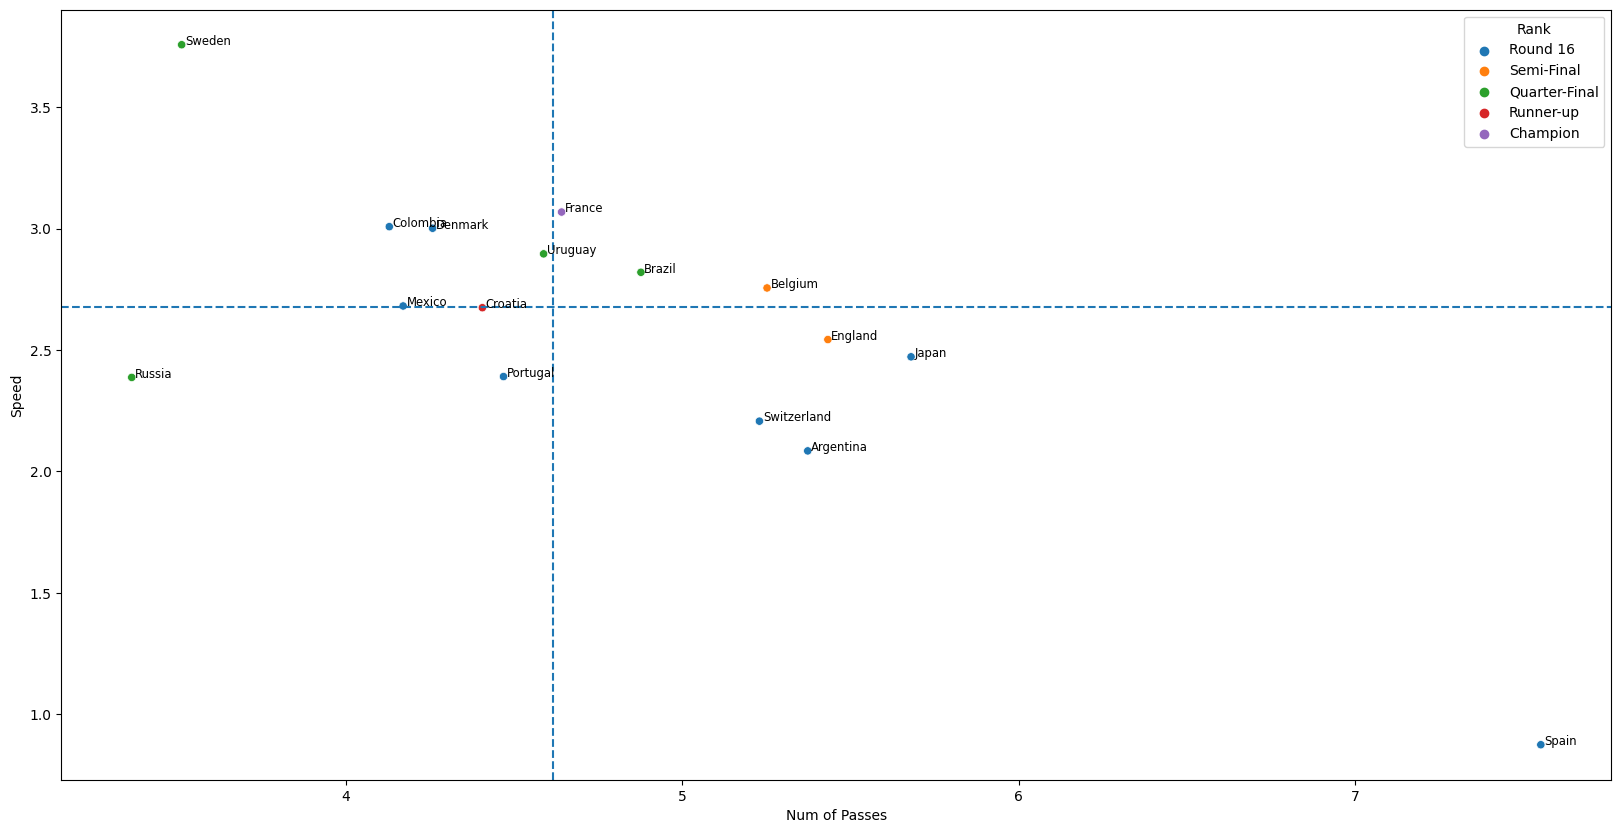

In [ ]:
# Visualizing that style
speed_med = team_style_grouped['Speed'].median()
pass_med = team_style_grouped['Num of Passes'].median()
ax = plt.figure(figsize=(20,10))
plt1 = sns.scatterplot(data = team_style_grouped, x='Num of Passes', y='Speed',hue = 'Rank')
plt1.axvline(x = pass_med, ymin = 0, ymax = 1,linestyle = "dashed")
plt1.axhline(y = speed_med, xmin = 0, xmax = 1,linestyle = "dashed")
for line in range(0,team_style_grouped.shape[0]):
     plt1.text(team_style_grouped['Num of Passes'][line]+0.01, team_style_grouped.Speed[line],
     team_style_grouped.index[line], horizontalalignment='left',
     size='small')

In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Offside'
 'Others on the ball' 'Pass' 'Save attempt' 'Shot']
['1H' '2H' 'E1' 'E2']


In [ ]:
# Dividing the data in train and test subsets
y = perform_encoded.Successful
X = perform_encoded.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_train)
accuracy_score(y_train,y_pred)

1.0

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=5)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.0007764381905497539}
0.8396753387506124


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8242245199409158

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/World Cup/WC_DT.png')

True

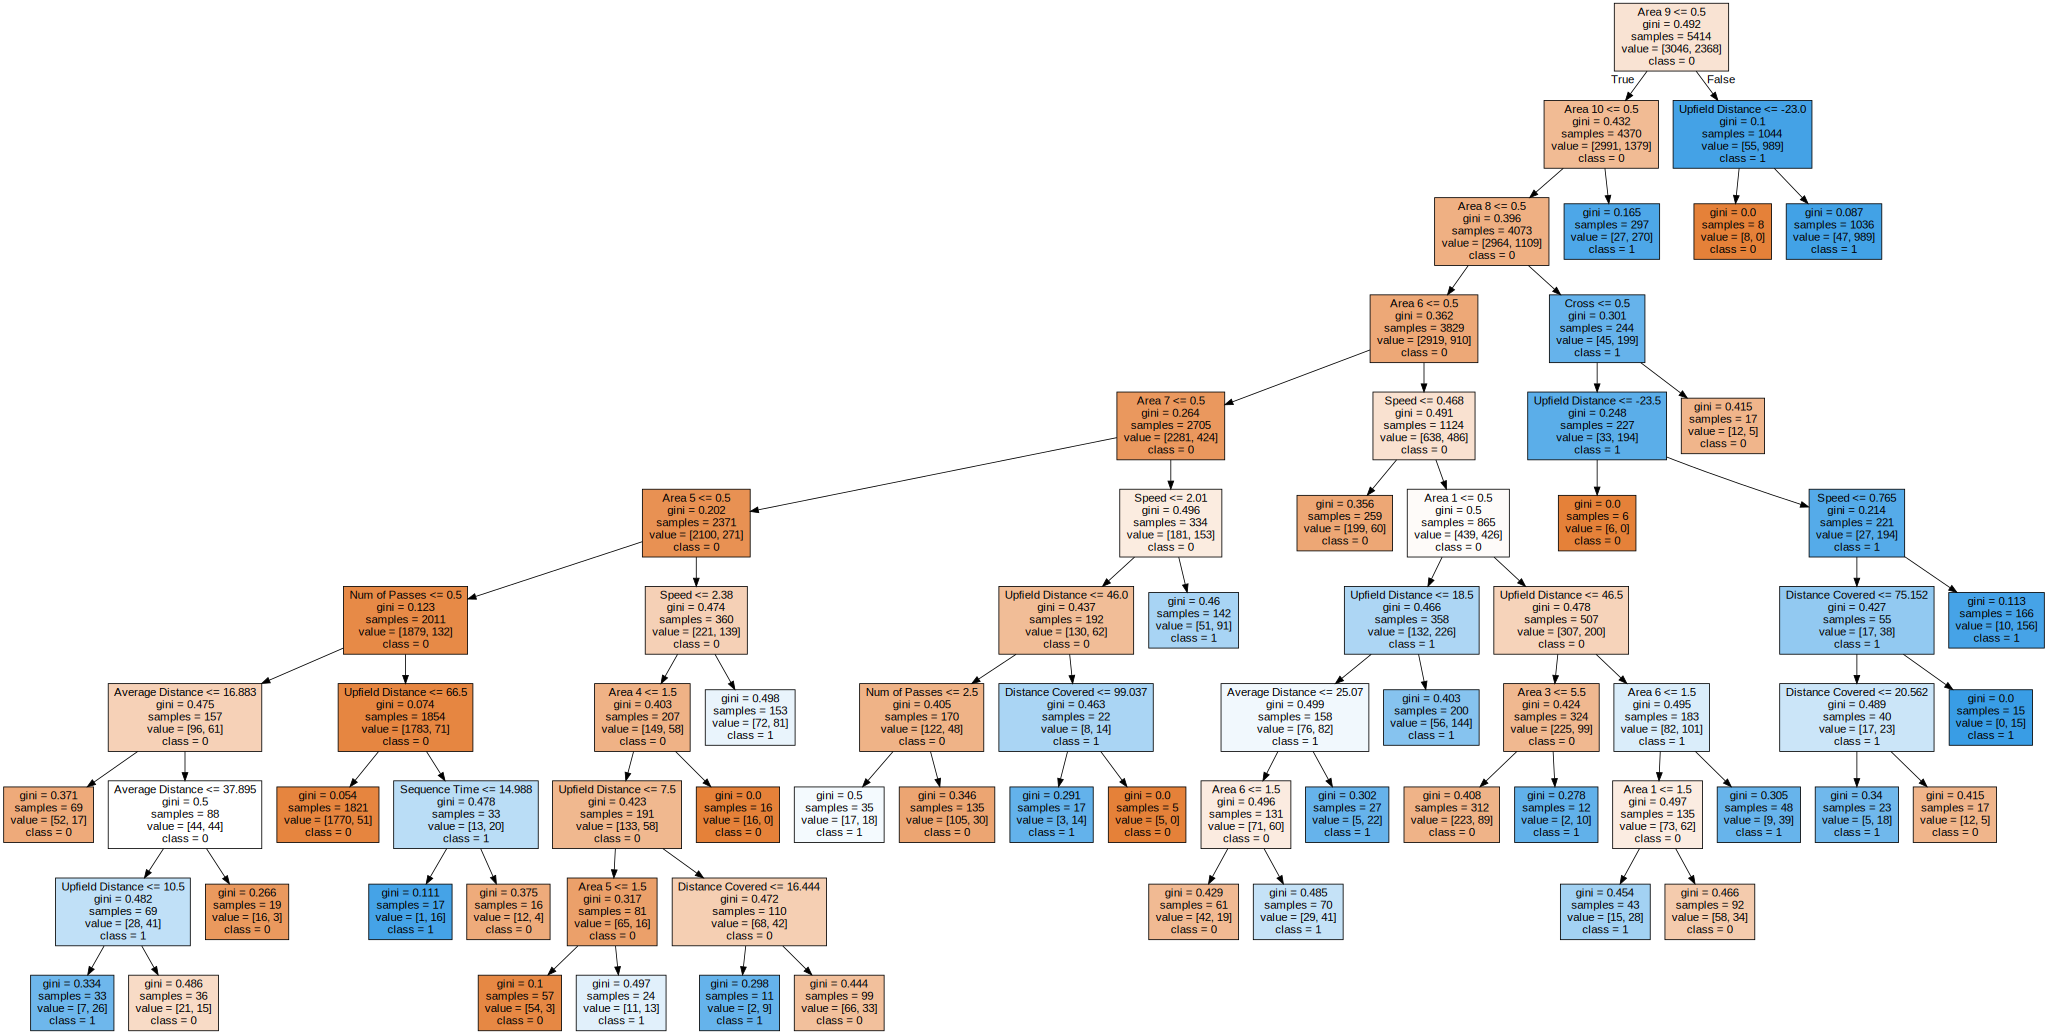

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

# Question 2:	How can event sequence analysis identify the key players and positions that contribute most to a team's success in football, and what insights can be gained from this analysis?

In [ ]:
# Transforming the teams data to H5 format
teams.to_hdf('WC.h5', key='teams', mode='w')

# Transforming the players data to H5 format
players.to_hdf('WC.h5', key='players', mode='a')

# Transforming the matches data to H5 format
matches.to_hdf('WC.h5', key='matches', mode='a')

# Transforming the event data to H5 format grouped per
events_grouped_per_match = WC.groupby('matchId', as_index=False)
for id, events_per_match in events_grouped_per_match:
  events_per_match.to_hdf('WC.h5', key=f'events/match_{id}', mode='a')

# Converting the above data to SPAL format
convert_to_spadl('WC.h5', 'spadl.h5')

<ipython-input-74-634215b939d7>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['passportArea', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'role', 'birthArea', 'foot', 'shortName',
       'currentNationalTeamId'],
      dtype='object')]

  players.to_hdf('WC.h5', key='players', mode='a')
<ipython-input-74-634215b939d7>:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['status', 'teamsData', 'dateutc', 'venue', 'label', 'groupName',
       'referees', 'duration'],
      dtype='object')]

  matches.to_hdf('WC.h5', key='matches', mode='a')
<ipython-input-74-634215b939d7>:13: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map dir

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 64/64 [00:08<00:00,  7.95game/s]


...Converting events to actions


100%|██████████| 64/64 [00:41<00:00,  1.53game/s]


In [ ]:
# Reading the required datasets from the SPAL format
games = pd.read_hdf('spadl.h5', key='games')
action_types = pd.read_hdf('spadl.h5', key='actiontypes')
body_parts = pd.read_hdf('spadl.h5', key='bodyparts')
results = pd.read_hdf('spadl.h5', key='results')

In [ ]:
# Grouping all the necessary feature generators
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

# Retrieving the column names generated by the features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)

# Grouping the target feature generators
functions_labels = [labels.scores,labels.concedes]
target_features = ['scores','concedes']

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Transforming the events to Game States
    gamestates = features.gamestates(actions, nb_prev_actions=3)
    gamestates = features.play_left_to_right(gamestates, game['home_team_id'])

# Extracting the features stated above and transforming it to H5 format
    features_df = pd.concat([function(gamestates) for function in functions_features], axis=1)
    features_df.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Extracting the labels stated above and transforming it to H5 format
    labels_df = pd.concat([function(actions) for function in functions_labels], axis=1)
    labels_df.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Retreiving the relevant features and transforming them into a panda dataframe
features_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    features_per_game = pd.read_hdf('features.h5', key=f'game_{game_id}')
    features_list.append(features_per_game[columns_features])
features_df = pd.concat(features_list).reset_index(drop=True)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
features_df.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,52.504404,0.012952,52.504404,0.012952,52.504404,0.012952,True,True,0.000000,0.000000
1,False,False,False,False,False,False,False,False,False,False,...,64.064437,0.021230,52.504404,0.012952,52.504404,0.012952,True,True,0.998518,0.998518
2,True,False,False,False,False,False,False,False,False,False,...,71.195733,0.231284,64.064437,0.021230,52.504404,0.012952,True,True,0.998518,1.997036
3,True,False,False,False,False,False,False,False,False,False,...,79.102640,0.378628,71.195733,0.231284,64.064437,0.021230,True,True,2.251571,3.250089
4,True,False,False,False,False,False,False,False,False,False,...,94.005013,0.108719,79.102640,0.378628,71.195733,0.231284,True,True,3.085624,5.337195


In [ ]:
# Retreiving the relevant labels and transforming them into a panda dataframe
labels_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    labels_per_game = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    labels_list.append(labels_per_game[target_features])
labels_df = pd.concat(labels_list).reset_index(drop=True)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
labels_df.head()

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [ ]:
print(len(labels_df))
print(len(labels_df))

80979
80979


In [ ]:
# Training a classifier model for each label
models = {}
for label in target_features:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(features_df, labels_df[label])
    models[label] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# Using the trained models to transform the labels dataframe from true/false to probability of being true
probabilities_dict = {}
for label in target_features:
    model = models[label]
    probabilities = model.predict_proba(features_df)
    predictions = probabilities[:, 1]
    probabilities_dict[label] = pd.Series(predictions)
probabilities_df = pd.concat(probabilities_dict, axis=1)

In [ ]:
# Extracting the game ids to have them with probabilties df and merging both into one
games_ids_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    games_ids_list.append(actions['game_id'])
game_ids_df = pd.concat(games_ids_list, axis=0).astype('int').reset_index(drop=True)
probabilities_df = pd.concat([probabilities_df, game_ids_df], axis=1)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the probabilities looks
probabilities_df.head()

,scores,concedes,game_id
0,0.000416,0.007402,2058017
1,0.000832,0.003002,2058017
2,0.000740,0.000281,2058017
3,0.002485,0.014459,2058017
4,0.003326,0.001226,2058017


In [ ]:
# Grouping the probabilities by match
probabilities_per_game = probabilities_df.groupby('game_id')

# Saving them in H5 format
for game_id, probabilities in tqdm(probabilities_per_game):
    probabilities = probabilities.reset_index(drop=True)
    probabilities[target_features].to_hdf('probabilities.h5', key=f'game_{game_id}')

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# VAEP Calculations
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []

for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .merge(players, how='left')
        .merge(teams, how='left')
        .reset_index(drop=True)
    )
    probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
    values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
    all_df = pd.concat([actions, probabilities_df, values], axis=1)
    all_per_game.append(all_df)

# transforming all to pandas dataframe
vaep_rating = pd.concat(all_per_game)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Extracting minutes played by player
player_games = pd.read_hdf('spadl.h5', 'player_games')
player_games = player_games[player_games['game_id'].isin(games['game_id'])]
minutes_played = (player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
# Aggregating the results and grouping them by player
players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

# Adding column minutes played total per player
players_ratings = players_ratings.merge(minutes_played)

# Removing any player plaing less than 90 minutes (1 World Cup match)
players_ratings = players_ratings[players_ratings['minutes_played'] > 90]

# Transforming VAEP to show players rating per match
players_ratings['vaep_per_match'] = players_ratings['vaep_sum'] * 90 / players_ratings['minutes_played']

# Average actions per plaer per match
players_ratings['actions_per_match'] = players_ratings['vaep_count'] * 90 / players_ratings['minutes_played']

# Sorting value by VAEP per match
players_ratings = players_ratings.sort_values('vaep_per_match', ascending=False)

In [ ]:
# Adding two more columns that describes VAEP rating into success and fail actions
risk = pd.pivot_table(vaep_rating, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
risk = risk.reset_index()
risk = risk[0:-1]
risk = risk[['player_id','success','fail']]

# Merging these two columns with the players ratings
players_ratings = pd.merge(players_ratings, risk, on=['player_id'])

# Normalizing them to 90 minutes
players_ratings['success'] = players_ratings['success'] / players_ratings['minutes_played'] * 90
players_ratings['fail'] = players_ratings['fail'] / players_ratings['minutes_played'] * 90

In [ ]:
# Visualizing the players ratings
players_ratings.head()

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
0,86340.0,Uruguay,C. Sánchez,89,1.965586,0.022085,134.064501,1.319535,59.747360,0.881167,0.438368
1,8945.0,England,K. Trippier,447,5.812042,0.013002,541.159246,0.966599,74.340410,1.025956,-0.059357
2,213364.0,Uruguay,G. De Arrascaeta,60,0.914668,0.015244,90.525172,0.909361,59.651916,1.130050,-0.220689
3,265673.0,Portugal,Bernardo Silva,193,2.439365,0.012639,251.413297,0.873235,69.089425,0.753651,0.119583
4,91019.0,Colombia,J. Quintero,242,2.890193,0.011943,314.111459,0.828105,69.338445,0.829237,0.002815


In [ ]:
# Getting the top 4 leagues positions data
api=StatsBombLoader(getter="remote",creds=None)
wc = api.games(competition_id=43,season_id=3)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [ ]:
list_of_players = []
# Extracting the position of players in La Liga
unique_games = wc['game_id'].unique()
for game in unique_games:
  plrs = api.players(game_id=	game)
  tms = api.teams(game_id=game)
  plrs_merged = pd.merge(plrs,tms, on=["team_id"])
  extracted = plrs_merged[['player_id','player_name','starting_position_name','team_name']]
  list_of_players.append(extracted)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

In [ ]:
# Putting all together
players_position = pd.concat(list_of_players)
players_position.head()

,player_id,player_name,starting_position_name,team_name
0,3094,Bamidele Alli,Left Attacking Midfield,England
1,3205,Kyle Walker,Right Center Back,England
2,3233,Raheem Sterling,Right Center Forward,England
3,3244,John Stones,Center Back,England
4,3293,Jesse Lingard,Right Attacking Midfield,England


In [ ]:
# Determining the position the most played by each player
names = []
position = []
for name in players_position.player_name.unique():
  position_per_player = players_position[players_position['player_name']==name]
  names.append(name)
  if position_per_player.starting_position_name.value_counts().index[0] == 'Substitute':
    try:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[1])
    except:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
  else:
    position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
players_position = pd.DataFrame(list(zip(names, position)),columns =['player_name', 'position'])

In [ ]:
# Function that matches names from 2 Dataframes
def fuzzy_merge(df_1, df_2, key1, key2, threshold=0, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit,scorer=fuzz.token_set_ratio ))
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    return df_1

In [ ]:
# Applying the function
players_ratings = fuzzy_merge(players_ratings, players_position, 'short_name', 'player_name')

In [ ]:
# Creating a new column for each player and his position
positions = []
for id,row in players_ratings.iterrows():
  player = row['matches']
  info = players_position[players_position['player_name']==player]
  position = info['position'].iloc[0]
  positions.append(position)
players_ratings['position'] = positions

In [ ]:
# Understanding the number of players in each position
players_ratings.groupby(['position'])['position'].count()


position
Center Attacking Midfield    17
Center Back                   4
Center Defensive Midfield    12
Center Forward               38
Center Midfield               3
Goalkeeper                   42
Left Attacking Midfield       3
Left Back                    34
Left Center Back             51
Left Center Forward           8
Left Center Midfield         35
Left Defensive Midfield       8
Left Midfield                19
Left Wing                    21
Left Wing Back                3
Right Attacking Midfield      2
Right Back                   41
Right Center Back            44
Right Center Forward          7
Right Center Midfield        28
Right Defensive Midfield      9
Right Midfield               19
Right Wing                   26
Right Wing Back               1
Secondary Striker             1
Substitute                    4
Name: position, dtype: int64

In [ ]:
# Putting all CBs, RCBs and LCBs as CBs
players_ratings.replace('Left Center Back','Center Back', inplace = True)
players_ratings.replace('Right Center Back','Center Back', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Center Forward','Center Forward', inplace = True)
players_ratings.replace('Right Center Forward','Center Forward', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Defensive Midfield','Center Defensive Midfield', inplace = True)
players_ratings.replace('Right Defensive Midfield','Center Defensive Midfield', inplace = True)

# Putting all CAMs, RCAMs and LCAMs as CAMs
players_ratings.replace('Left Attacking Midfield','Center Attacking Midfield', inplace = True)
players_ratings.replace('Right Attacking Midfield','Center Attacking Midfield', inplace = True)
players_ratings.replace('Secondary Striker','Center Attacking Midfield', inplace = True)

# Putting all RWBs to RBs and LWBs to LBs
players_ratings.replace('Left Wing Back','Left Back', inplace = True)
players_ratings.replace('Right Wing Back','Right Back', inplace = True)
players_ratings.replace('Center Midfield','Right Center Midfield', inplace = True)

In [ ]:
# Abbreviating all positions
players_ratings.replace('Left Center Midfield','LCM', inplace = True)
players_ratings.replace('Center Attacking Midfield','CAM', inplace = True)
players_ratings.replace('Left Wing','LW', inplace = True)
players_ratings.replace('Right Midfield','RM', inplace = True)
players_ratings.replace('Right Wing','RW', inplace = True)
players_ratings.replace('Right Center Midfield','RCM', inplace = True)
players_ratings.replace('Substitute','Sub', inplace = True)
players_ratings.replace('Left Back','LB', inplace = True)
players_ratings.replace('Center Defensive Midfield','CDM', inplace = True)
players_ratings.replace('Left Midfield','LM', inplace = True)
players_ratings.replace('Center Forward','CF', inplace = True)
players_ratings.replace('Right Back','RB', inplace = True)
players_ratings.replace('Center Back','CB', inplace = True)
players_ratings.replace('Goalkeeper','GK', inplace = True)

In [ ]:
# Aggregating and grouping by player position
positions_ranks = players_ratings.groupby(['position']).mean()

<ipython-input-204-ea2832b3073a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks = players_ratings.groupby(['position']).mean()


In [ ]:
# Seeing the table
positions_ranks

,player_id,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
position,,,,,,,,,
CAM,89338.304348,178.478261,0.433533,0.001976,289.834909,0.114032,55.481004,0.170920,-0.056719
CB,91908.818182,187.373737,0.226642,0.001105,275.984307,0.065430,60.510731,0.075540,-0.010099
CDM,98682.965517,183.034483,0.323101,0.002054,252.347667,0.109829,62.872160,0.166355,-0.056771
CF,77533.320755,105.660377,0.304897,0.002533,267.005807,0.081396,34.517261,0.153182,-0.072561
GK,77183.547619,105.785714,0.353268,0.003018,295.861713,0.097280,32.304187,0.087602,0.009878
LB,95274.567568,170.135135,0.180928,0.001377,250.886474,0.046785,60.316541,0.071085,-0.010913
LCM,104895.400000,218.714286,0.369485,0.001506,286.905088,0.100656,67.108906,0.134007,-0.033127
LM,76869.631579,140.473684,0.298217,0.001747,248.058626,0.090442,50.490598,0.138570,-0.047220
LW,135867.857143,132.952381,0.349505,0.002061,251.455112,0.105622,47.657662,0.186728,-0.079562


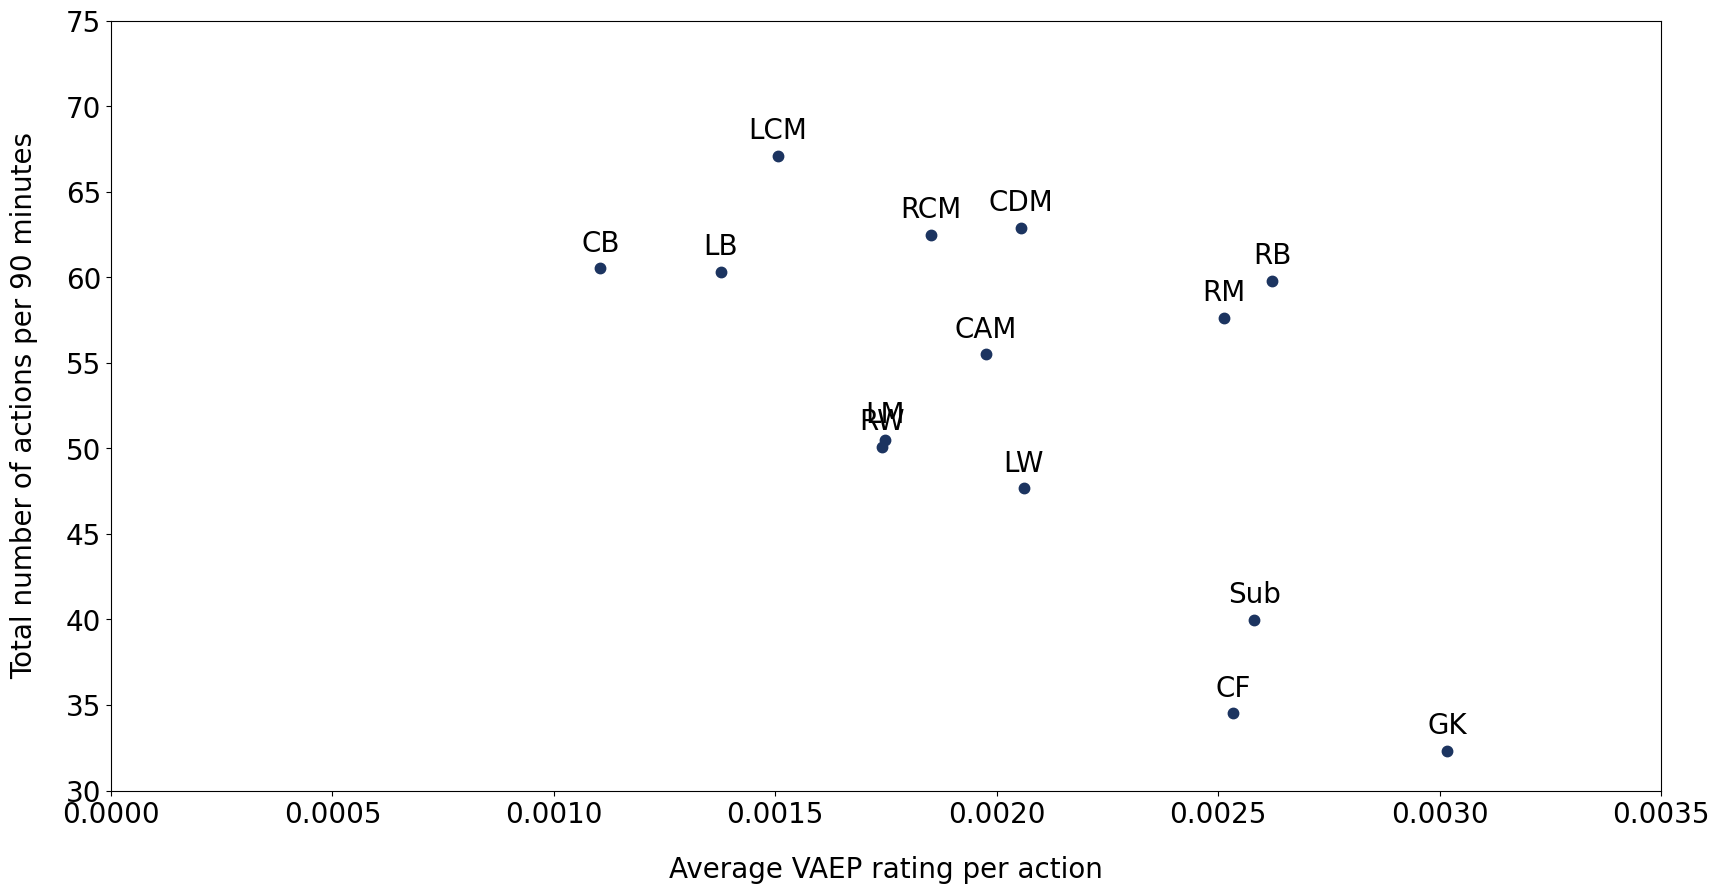

In [ ]:
# Analyzing Quantity vs Quality
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['vaep_mean'])
y = list(positions_ranks['actions_per_match'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 1), fontsize=20, horizontalalignment='center')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.0035)
plt.ylim(30, 75)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total number of actions per 90 minutes', labelpad=20, fontsize=20)
plt.show()

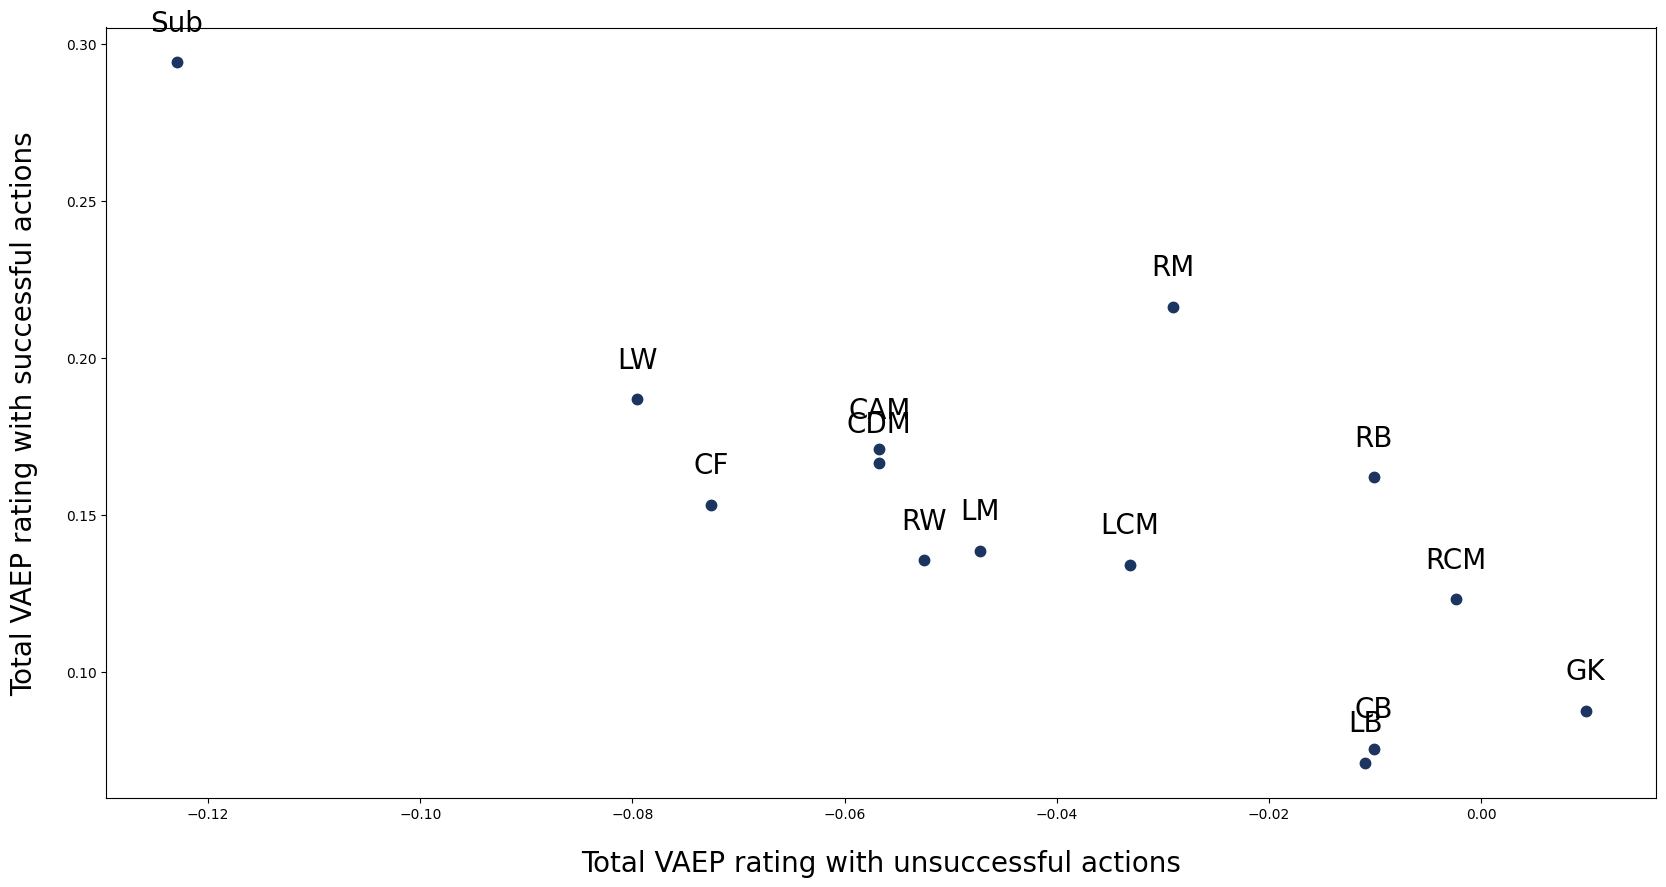

In [ ]:
# Analyzing Risk taken by position
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['fail'])
y = list(positions_ranks['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]+ 0.01), fontsize=20, horizontalalignment='center')

plt.xlabel('Total VAEP rating with unsuccessful actions', labelpad=20, fontsize=20)
plt.ylabel('Total VAEP rating with successful actions', labelpad=20, fontsize=20)
plt.show()

In [ ]:
# Getting Best 3 position by Club
positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])

<ipython-input-212-d70c56c1ffbc>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])


In [ ]:
# Getting Best 3 position for semi-finalists
finalist = ['France', 'Croatia']
finalist_df = pd.concat( [ positions_ranks_by_club.groupby(level=0).get_group(i) for i in finalist] )
finalist_df.groupby(level=0).head(3)

player_id  vaep_count  vaep_sum  vaep_mean  \
team_name position                                               
France    CAM          3682.0       340.0  3.601596   0.010593   
          RW         353833.0       261.0  2.145933   0.008222   
          LW          27179.5       111.0  0.600505   0.004273   
Croatia   LCM         36440.0       365.5  1.575936   0.003653   
          RCM          8287.0       656.0  1.232563   0.001879   
          LW          14812.0       302.0  1.120823   0.003711   

                    minutes_played  vaep_per_match  actions_per_match  \
team_name position                                                      
France    CAM           583.084159        0.555912          52.479560   
          RW            554.434820        0.348344          42.367469   
          LW            219.400621        0.190613          52.269202   
Croatia   LCM           359.499036        0.346109          99.169099   
          RCM           655.439736        0.169246          90.076931   
          LW            616.332009        0.163668          44.099608   

                     success      fail  
team_name position                      
France    CAM       0.604079 -0.048166  
          RW        0.297107  0.051237  
          LW        0.178567  0.024043  
Croatia   LCM       0.380293 -0.030287  
          RCM       0.427382 -0.257758  
          LW        0.185444 -0.021775

In [ ]:
# Getting Best 3 position for semi-finalists
semi = ['England', 'Belgium']
semi_df = pd.concat( [ positions_ranks_by_club.groupby(level=0).get_group(i) for i in semi] )
semi_df.groupby(level=0).head(3)

player_id  vaep_count  vaep_sum  vaep_mean  \
team_name position                                               
England   RM           8945.0       447.0  5.812042   0.013002   
          GK          10131.0       279.0  1.875333   0.006722   
          CDM        109004.0       279.0  1.010906   0.003331   
Belgium   RB          37824.0       308.0  1.989690   0.006460   
          RCM         24586.5       285.5  1.828015   0.005405   
          LB         134769.0       140.0  0.946100   0.006758   

                    minutes_played  vaep_per_match  actions_per_match  \
team_name position                                                      
England   RM            541.159246        0.966599          74.340410   
          GK            658.604335        0.256269          38.126078   
          CDM           337.293762        0.247133          79.914977   
Belgium   RB            470.183964        0.380855          58.955647   
          RCM           377.225053        0.367039          67.405363   
          LB            248.134200        0.343157          50.778974   

                     success      fail  
team_name position                      
England   RM        1.025956 -0.059357  
          GK        0.102764  0.153505  
          CDM       0.275573 -0.025431  
Belgium   RB        0.402484 -0.022252  
          RCM       0.360875  0.006163  
          LB        0.459657 -0.116458

In [ ]:
# Getting Best 3 position for quarter-finalists
quarter = ['Brazil','Uruguay','Sweden','Russia']
quarter_df = pd.concat( [ positions_ranks_by_club.groupby(level=0).get_group(i) for i in quarter] )
quarter_df.groupby(level=0).head(3)

player_id  vaep_count  vaep_sum  vaep_mean  \
team_name position                                               
Brazil    Sub        15808.00        68.0  0.750615   0.011038   
          RB         40707.00       284.0  1.461506   0.005146   
          LW         40810.00       406.0  1.534188   0.003779   
Uruguay   LW        213364.00        60.0  0.914668   0.015244   
          CF         14573.00       166.0  2.003488   0.013271   
          CB         81405.25       166.5  0.954901   0.007828   
Sweden    LB         51217.00       220.0  1.429756   0.006499   
          LCM        20876.00       220.0  1.112215   0.005056   
          RCM        20663.50       127.5  0.741320   0.004473   
Russia    LW          4513.00       157.0  1.652147   0.010523   
          CAM       257800.00       233.0  2.172371   0.009323   
          LB        101752.00       146.0  0.607000   0.004138   

                    minutes_played  vaep_per_match  actions_per_match  \
team_name position                                                      
Brazil    Sub           106.142052        0.636462          57.658580   
          RB            382.113264        0.344232          66.891161   
          LW            478.146889        0.288775          76.420031   
Uruguay   LW             90.525172        0.909361          59.651916   
          CF            416.247626        0.454816          35.471906   
          CB            271.249456        0.452986          57.341290   
Sweden    LB            476.684644        0.269944          41.536895   
          LCM           439.426007        0.227796          45.058780   
          RCM           238.342322        0.219369          41.425916   
Russia    LW            281.808909        0.527638          50.140359   
          CAM           384.863357        0.508007          54.486871   
          LB            259.226234        0.210434          51.012453   

                     success      fail  
team_name position                      
Brazil    Sub       1.061064 -0.424602  
          RB        0.350419 -0.005959  
          LW        0.561986 -0.273707  
Uruguay   LW        1.130050 -0.220689  
          CF        0.496039 -0.041224  
          CB        0.321885  0.131101  
Sweden    LB        0.195840  0.068297  
          LCM       0.144300  0.082219  
          RCM       0.238545 -0.019176  
Russia    LW        0.545413 -0.019984  
          CAM       0.554251 -0.048567  
          LB        0.216819 -0.009094

In [ ]:
# Getting Best 3 position for Round of 16
R16 = ['Switzerland','Japan','Colombia','Mexico','Spain','Denmark','Argentina','Portugal']
R16_df = pd.concat( [ positions_ranks_by_club.groupby(level=0).get_group(i) for i in R16] )
R16_df.groupby(level=0).head(3)

player_id  vaep_count  vaep_sum  vaep_mean  \
team_name   position                                                   
Switzerland RB         35221.000000  136.500000  0.262490   0.004249   
            RW         49872.000000  270.000000  0.942575   0.003491   
            LCM        49876.000000  396.000000  0.936179   0.002364   
Japan       LW         14836.000000  169.000000  0.948881   0.005615   
            CF         94831.000000  106.000000  0.923518   0.008712   
            CDM        54878.500000  275.000000  0.790814   0.002744   
Colombia    CAM        91019.000000  242.000000  2.890193   0.011943   
            GK         25662.000000  134.000000  2.404946   0.017947   
            CB        180304.666667  181.666667  0.935696   0.004547   
Mexico      CDM         3384.000000  183.000000  0.772029   0.004219   
            LB        336178.000000  230.000000  0.631561   0.002746   
            CF          7941.000000  104.000000  0.594304   0.005714   
Spain       RB          4501.000000  209.000000  1.170101   0.005599   
            CF          4338.000000   91.000000  1.488575   0.016358   
            Sub         3563.000000  597.000000  1.308042   0.002191   
Denmark     LB         55991.500000   92.000000  0.493869   0.005674   
            RW         56274.000000  130.000000  0.603161   0.004640   
            LCM        55990.000000  224.000000  0.729740   0.003258   
Argentina   LW        285396.000000   82.000000  0.431358   0.005260   
            CB         85869.000000  274.000000  0.505188   0.001943   
            LB         86722.000000  269.000000  0.533980   0.001985   
Portugal    RM        149135.000000  144.500000  1.569275   0.009961   
            GK         70134.000000  115.000000  1.251564   0.010883   
            RB         70385.000000  137.500000  0.430214   0.004119   

                      minutes_played  vaep_per_match  actions_per_match  \
team_name   position                                                      
Switzerland RB            198.658067        0.266711          62.046703   
            RW            369.098527        0.229835          65.836080   
            LCM           383.207330        0.219871          93.004484   
Japan       LW            305.083711        0.279921          49.855169   
            CF            320.068365        0.259684          29.806132   
            CDM           321.540299        0.211683          76.941468   
Colombia    CAM           314.111459        0.828105          69.338445   
            GK            380.242723        0.569229          31.716583   
            CB            311.198968        0.271589          51.349588   
Mexico      CDM           313.135239        0.221893          52.597082   
            LB            349.404276        0.162678          59.243694   
            CF            342.377318        0.156223          27.338260   
Spain       RB            214.438930        0.491091          87.717281   
            CF            320.000000        0.418662          25.593750   
            Sub           379.352674        0.310328         141.636012   
Denmark     LB            186.941909        0.290765          49.517803   
            RW            246.876102        0.219885          47.392194   
            LCM           377.890245        0.173798          53.348824   
Argentina   LW            166.490783        0.233180          44.326778   
            CB            306.984105        0.153492          79.599077   
            LB            364.181620        0.131962          66.477819   
Portugal    RM            189.163420        0.684529          68.583632   
            GK            383.414303        0.293783          26.994298   
            RB            191.707151        0.273989          65.533435   

                       success      fail  
team_name   position                      
Switzerland RB        0.320290 -0.053657  
            RW        0.248421 -0.021151  
            LCM       0.200830